# Libraries and Setup

In [18]:
import torchvision
from essentials import *
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
import gc

import warnings
warnings.filterwarnings('ignore')

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cpu


In [19]:
# Download the dog image if it doesn't exist
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

img = torchvision.io.read_image("dog.jpg")

dog.jpg exists


In [20]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled).to(device)

In [21]:
original_img = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
low_res_img = torchvision.transforms.functional.resize(original_img, (200, 200))

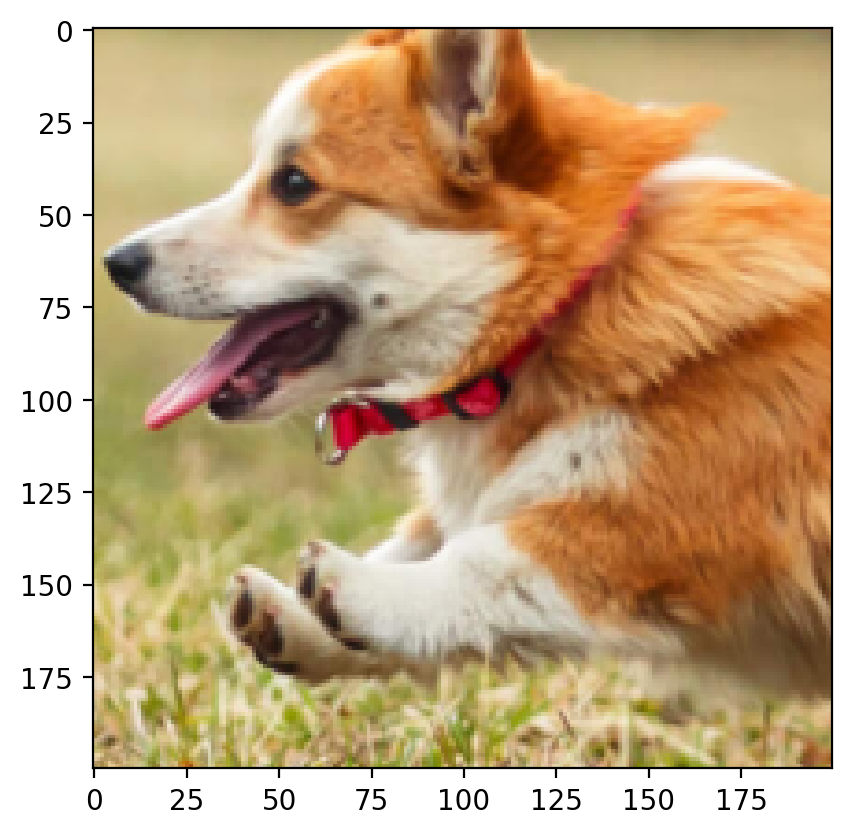

In [22]:
plt.imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())

In [23]:
original_img = original_img.to(device)
low_res_img = low_res_img.to(device)

In [24]:
feature_count = 30000
epoch_count = 1
sigma = 0.008
lr_rate = 0.01

In [25]:
torch.cuda.empty_cache()

dog_X_low, dog_Y_low = create_coordinate_map(low_res_img)
dog_Y_low = dog_Y_low.to(device)

scaler_low = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X_low.cpu())
scaled_X_low = torch.tensor(scaler_low.transform(dog_X_low.cpu())).float().to(device)

rff = RBFSampler(n_components=feature_count, gamma=1 / (2 * sigma ** 2), random_state=13)
X_rff_high = torch.tensor(rff.fit_transform(scaled_X_low.cpu().numpy())).float().to(device)

net = LinearModel(X_rff_high.shape[1], original_img.shape[0])
net.to(device)

train(net, lr_rate, X_rff_high, dog_Y_low, epoch_count)

Epoch 0 loss: 0.366690


0.3666902780532837

In [26]:
torch.cuda.empty_cache()
del X_rff_high, scaled_X_low, scaler_low, dog_X_low, dog_Y_low
gc.collect()

48

In [27]:
dog_X_high = create_coordinate_map(low_res_img, factor=2)[0]

scaler_high = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X_high.cpu())
scaled_X_high = torch.tensor(scaler_high.transform(dog_X_high.cpu())).float().to(device)

X_rff_high = torch.tensor(rff.transform(scaled_X_high.cpu().numpy())).float().to(device)

In [ ]:
num_channels, height, width = original_img.shape

with torch.no_grad():
    outputs = net(X_rff_high)
    outputs = outputs.reshape(height, width, num_channels)

plot_reconstructed_and_original_image(low_res_img.permute(1, 2, 0).cpu(), outputs.cpu(), title="Super Resolution Image with RFF features")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


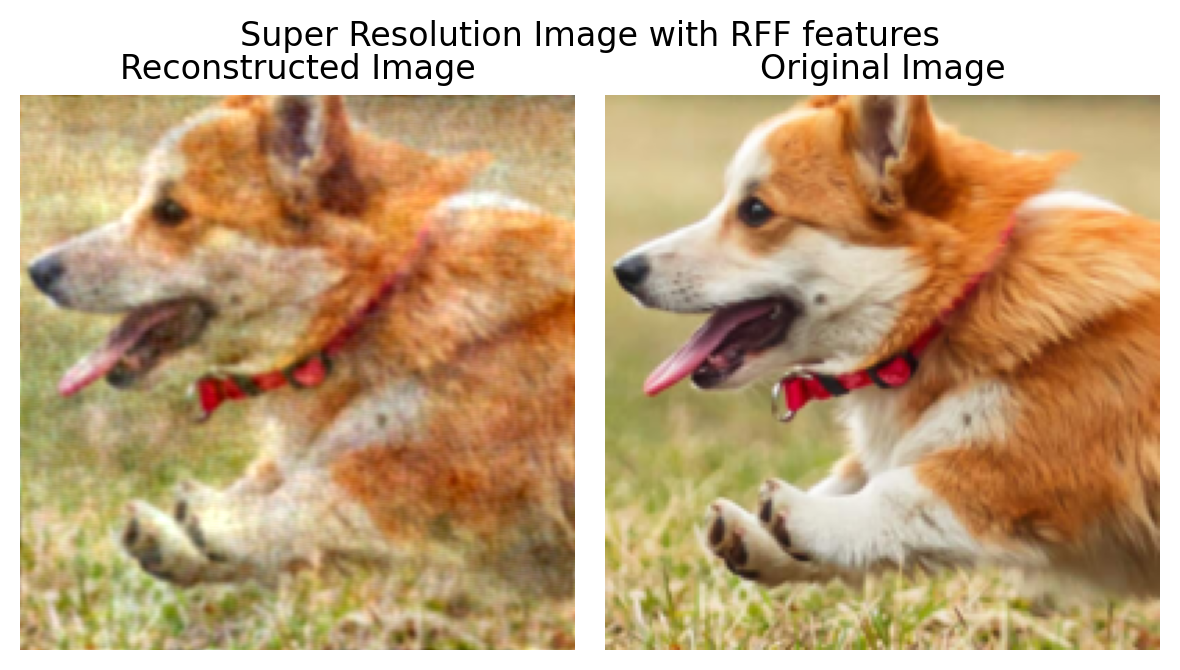

In [ ]:
num_channels, height, width = original_img.shape

with torch.no_grad():
    outputs = net(X_rff_high)
    outputs = outputs.reshape(height, width, num_channels)

plot_reconstructed_and_original_image(low_res_img.permute(1, 2, 0).cpu(), outputs.cpu(),
                                      title="Super Resolution Image with RFF features")

del X_rff_high, scaled_X_high, scaler_high, dog_X_high, dog_Y_high, outputs
gc.collect()
torch.cuda.empty_cache()